# CHAPTER 3: How to use Python data science packages more productively

---

## Why `Numpy` is faster than regular Python code and by how much

In [1]:
import numpy as np

### Numpy arrays are different

In [2]:
lst1 = [i for i in range(1,11)]
lst2 = [i*10 for i in range(1,11)]
print(lst1)
print(lst2)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [3]:
lst1+lst2

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [4]:
arr1 = np.array(lst1)
arr2 = np.array(lst2)

In [5]:
arr1+arr2

array([ 11,  22,  33,  44,  55,  66,  77,  88,  99, 110])

In [6]:
for p in dir(lst1):
    if '__' not in p:
        print(p, end=', ')

append, clear, copy, count, extend, index, insert, pop, remove, reverse, sort, 

In [7]:
for p in dir(arr1):
    if '__' not in p:
        print(p, end=', ')

T, all, any, argmax, argmin, argpartition, argsort, astype, base, byteswap, choose, clip, compress, conj, conjugate, copy, ctypes, cumprod, cumsum, data, diagonal, dot, dtype, dump, dumps, fill, flags, flat, flatten, getfield, imag, item, itemset, itemsize, max, mean, min, nbytes, ndim, newbyteorder, nonzero, partition, prod, ptp, put, ravel, real, repeat, reshape, resize, round, searchsorted, setfield, setflags, shape, size, sort, squeeze, std, strides, sum, swapaxes, take, tobytes, tofile, tolist, tostring, trace, transpose, var, view, 

## NumPy array vs. native Python computation

In [8]:
from functools import wraps
from time import time

def timing(func):
    @wraps(func)
    def wrap(*args, **kw):
        ts = time()
        result = func(*args, **kw)
        te = time()
        tdelta = round(1000*(te-ts),3)
        print (f"Function '{func.__name__}' took {tdelta} milliseconds to run")
        return result
    return wrap

In [9]:
@timing
def std_dev(a):
    if isinstance(a,list):
        a = np.array(a)
    s = a.std()
    return s

In [10]:
from math import sqrt
@timing
def std_dev_python(lst):
    s = sum(lst)
    av = s/len(lst)
    sumsq = 0
    for i in lst:
        sumsq+=(i-av)**2
    sumsq_av = sumsq/len(lst)
    result = sqrt(sumsq_av)
    return result

In [11]:
a = np.arange(1000000)
lst = [i for i in range(1000000)]

In [12]:
std_dev(a)

Function 'std_dev' took 13.001 milliseconds to run


288675.1345946685

In [13]:
std_dev_python(lst)

Function 'std_dev_python' took 258.982 milliseconds to run


288675.1345958226

In [14]:
std_dev(lst)

Function 'std_dev' took 94.002 milliseconds to run


288675.1345946685

## Using Numpy efficiently

### Conversion first, operation later

In [15]:
lst_of_nums = [i for i in range(100000)]

def calc_nums(x):
    return (x+1)/(x+1000)

In [16]:
%%timeit -n10 -r10
result_lst = []
for i in lst_of_nums:
    result_lst.append(calc_nums(i))
result_array = np.array(result_lst)

28.9 ms ± 5.76 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [17]:
%%timeit -n10 -r10
array_of_nums = np.array(lst_of_nums)
result_array = (array_of_nums+1)/(array_of_nums+1000)

7.17 ms ± 655 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


### Vectorize logical operations too

In [18]:
lst_of_nums = [i for i in range(1000000)]

In [19]:
result_lst = []
for i in lst_of_nums:
    if i%7==0:
        result_lst.append(calc_nums(i))
result_array = np.array(result_lst)

In [20]:
result_array[:5]

array([0.001     , 0.00794439, 0.0147929 , 0.0215475 , 0.02821012])

In [21]:
array_of_nums = np.array(lst_of_nums)
array_div7 =  array_of_nums[array_of_nums%7==0]
result_array = (array_div7+1)/(array_div7+1000)

In [22]:
result_array[:5]

array([0.001     , 0.00794439, 0.0147929 , 0.0215475 , 0.02821012])

### Use `numpy.vectorize`

In [23]:
N_point = 100000

In [24]:
from math import sin
def myfunc(x,y):
    if (x>0.5*y and y<0.3):
        return (sin(x-y))
    elif (x<0.5*y):
        return 0
    elif (x>0.2*y):
        return (2*sin(x+2*y))
    else:
        return (sin(y+x))

In [25]:
lst_x = np.random.randn(N_point).tolist()
lst_y = np.random.randn(N_point).tolist()

In [26]:
%%timeit -n10 -r30
result_lst = []
for i in range(len(lst_x)):
    x = lst_x[i]
    y= lst_y[i]
    result_lst.append(myfunc(x,y))
result_array = np.array(result_lst)

38.3 ms ± 1.65 ms per loop (mean ± std. dev. of 30 runs, 10 loops each)


In [27]:
vectfunc = np.vectorize(myfunc,
                        otypes=[np.float64],
                        cache=False)

In [28]:
%%timeit -n10 -r30
result_array=vectfunc(lst_x,lst_y)

30.1 ms ± 880 µs per loop (mean ± std. dev. of 30 runs, 10 loops each)


In [29]:
vectfunc = np.vectorize(myfunc,
                        otypes=[np.float16],
                        cache=False)

In [30]:
%%timeit -n10 -r30
result_array=vectfunc(lst_x,lst_y)

35 ms ± 4.3 ms per loop (mean ± std. dev. of 30 runs, 10 loops each)


### Don't do `numpy.append`

In [31]:
desired_length = 1000

In [32]:
%%timeit -n10 -r30
results = np.empty(desired_length)
for i in range(desired_length):
    sample = np.random.normal()
    results[i] = sample**2

3.31 ms ± 577 µs per loop (mean ± std. dev. of 30 runs, 10 loops each)


In [33]:
%%timeit -n10 -r30
result_lst = []
for i in range(desired_length):
    sample = np.random.normal()
    result_lst.append(sample**2)
result_array = np.array(result_lst)    

3.44 ms ± 588 µs per loop (mean ± std. dev. of 30 runs, 10 loops each)


In [34]:
%%timeit -n10 -r30
result_array = np.array([])
for i in range(desired_length):
    sample = np.random.normal()
    np.append(result_array,sample**2)

7.88 ms ± 952 µs per loop (mean ± std. dev. of 30 runs, 10 loops each)


In [35]:
TERMINATE = np.random.normal()
result_lst = []
while TERMINATE < 2.0:
    sample = np.random.normal()
    result_lst.append(sample**2)
    TERMINATE = np.random.normal()
result_array = np.array(result_lst)

In [36]:
result_array

array([0.34610599, 0.44906169, 0.52442493])

### Reading

In [37]:
num_string = ', '.join([str(i) for i in range(1,100000)])

In [38]:
%%timeit -n10 -r30
num_lst = num_string.split(', ')
a = np.array(num_lst, dtype=np.int32)

16.5 ms ± 983 µs per loop (mean ± std. dev. of 30 runs, 10 loops each)


In [39]:
a

array([     0,      1,      2, ..., 999997, 999998, 999999])

In [40]:
%%timeit -n10 -r30
a = np.fromstring(num_string,sep=', ', dtype=np.int32)

16.8 ms ± 790 µs per loop (mean ± std. dev. of 30 runs, 10 loops each)


In [41]:
a

array([     0,      1,      2, ..., 999997, 999998, 999999])

In [42]:
iterable = [x*x for x in range(1000000)]

In [43]:
%%timeit -n10 -r30
a = np.fromiter(iterable, float,count=1000)

47.4 µs ± 11.9 µs per loop (mean ± std. dev. of 30 runs, 10 loops each)


In [44]:
%%timeit -n10 -r30
a = np.array(iterable[:1000],dtype=float)

The slowest run took 5.32 times longer than the fastest. This could mean that an intermediate result is being cached.
115 µs ± 58 µs per loop (mean ± std. dev. of 30 runs, 10 loops each)


In [45]:
%%timeit -n10 -r30
std = np.empty(1000)
for i in range(1000):
    slice = iterable[i:i+1000]
    a = np.fromiter(slice, float)
    std[i] = a.std()

65.5 ms ± 2.53 ms per loop (mean ± std. dev. of 30 runs, 10 loops each)


In [46]:
with open('fdata.txt', 'w') as fdata:
    for _ in range(10000):
        fdata.write(str(10*np.random.random())+',')

In [47]:
fr = np.fromfile('fdata.txt',sep=',')

In [48]:
fr

array([9.9750432 , 5.62649086, 3.37101379, ..., 6.73681038, 6.79961344,
       9.14569117])

In [49]:
with open('fdata.txt') as f:
    data = f.readline()
data = data.split(',')
fr = np.array(data[:-1],dtype=float)

In [50]:
fr

array([9.9750432 , 5.62649086, 3.37101379, ..., 6.73681038, 6.79961344,
       9.14569117])

In [51]:
np.loadtxt('npread.txt',delimiter=',')

array([[  9.2,  22.1, -33.6],
       [  6.4,   2.3,  -5.4],
       [ 12.2,   4.5,   7.2]])

In [52]:
np.loadtxt('npread.txt',delimiter=',',usecols=(0,2))

array([[  9.2, -33.6],
       [  6.4,  -5.4],
       [ 12.2,   7.2]])

---

## Using Pandas efficiently

### Setting values in a new DataFrame

In [53]:
from datetime import date
import pandas as pd

In [54]:
today=date(2021,9,20)

In [55]:
profile_data = ['First name', 'Last name', 30, 'An address', 25.2, today]

In [56]:
profile_data

['First name', 'Last name', 30, 'An address', 25.2, datetime.date(2021, 9, 20)]

In [57]:
N = 2000
df = pd.DataFrame(columns = ['FirstName', 'LastName','Age','Address','Price','Date'])

In [58]:
%%timeit -n5 -r10
for i in range(N):
    df.at[i] = profile_data

185 ms ± 60.9 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [59]:
%%timeit -n5 -r10
for i in range(N):
    df.iloc[i] = profile_data

109 ms ± 6.3 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [60]:
df.head()

FirstName   LastName Age     Address Price        Date
0  First name  Last name  30  An address  25.2  2021-09-20
1  First name  Last name  30  An address  25.2  2021-09-20
2  First name  Last name  30  An address  25.2  2021-09-20
3  First name  Last name  30  An address  25.2  2021-09-20
4  First name  Last name  30  An address  25.2  2021-09-20

In [61]:
profile_data = ['First name 2', 'Last name 2', 40, 'An address 2', 30.7, today]

In [62]:
%%timeit -n5 -r10
for i in range(N):
    df.values[i] = profile_data

12.2 ms ± 1.96 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [63]:
df.head()

FirstName     LastName Age       Address Price        Date
0  First name 2  Last name 2  40  An address 2  30.7  2021-09-20
1  First name 2  Last name 2  40  An address 2  30.7  2021-09-20
2  First name 2  Last name 2  40  An address 2  30.7  2021-09-20
3  First name 2  Last name 2  40  An address 2  30.7  2021-09-20
4  First name 2  Last name 2  40  An address 2  30.7  2021-09-20

### Specifying data types whenever possible

In [64]:
df_sample = pd.read_csv("Large-data.csv", nrows=20)

In [65]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         20 non-null     int64  
 1   credit.policy      20 non-null     int64  
 2   purpose            20 non-null     object 
 3   int.rate           20 non-null     float64
 4   installment        20 non-null     float64
 5   log.annual.inc     20 non-null     float64
 6   dti                20 non-null     float64
 7   fico               20 non-null     int64  
 8   days.with.cr.line  20 non-null     float64
 9   revol.bal          20 non-null     int64  
 10  revol.util         20 non-null     float64
 11  inq.last.6mths     20 non-null     int64  
 12  delinq.2yrs        20 non-null     int64  
 13  pub.rec            20 non-null     int64  
 14  not.fully.paid     20 non-null     int64  
dtypes: float64(6), int64(8), object(1)
memory usage: 2.5+ KB


In [66]:
dt = {}
for col,dtyp in zip(df_sample.columns,df_sample.dtypes):
    dt[col] = dtyp

In [67]:
dt

{'Unnamed: 0': dtype('int64'),
 'credit.policy': dtype('int64'),
 'purpose': dtype('O'),
 'int.rate': dtype('float64'),
 'installment': dtype('float64'),
 'log.annual.inc': dtype('float64'),
 'dti': dtype('float64'),
 'fico': dtype('int64'),
 'days.with.cr.line': dtype('float64'),
 'revol.bal': dtype('int64'),
 'revol.util': dtype('float64'),
 'inq.last.6mths': dtype('int64'),
 'delinq.2yrs': dtype('int64'),
 'pub.rec': dtype('int64'),
 'not.fully.paid': dtype('int64')}

In [68]:
df1 = pd.read_csv("Large-data.csv",dtype = dt)

In [69]:
def csv_read(filename):
    """
    Reads a CSV file with explicit data types
    """
    # Reads only the first 20 rows
    df_sample = pd.read_csv(filename, nrows=20)
    # Constructs data type dictionary
    dt = {}
    for col,dtyp in zip(df_sample.columns,df_sample.dtypes):
        dt[col] = dtyp
    # Full read with explicit data type
    df1 = pd.read_csv(filename,dtype = dt)
    
    return df1

### Using modern, optimized file formats

In [70]:
import pyarrow as pa
import pandas as pd
import pyarrow.parquet as pq

df = pd.DataFrame({"a": [1, 2, 3], 
                   "b":[2.7,-1.2,5.4], 
                   "c": ['abc','xyz','pqr']})
# Convert from pandas to Arrow
table = pa.Table.from_pandas(df)
# Convert back to pandas
df_new = table.to_pandas()

In [71]:
table.schema

a: int64
b: double
c: string
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 562

In [72]:
df_new

a    b    c
0  1  2.7  abc
1  2 -1.2  xyz
2  3  5.4  pqr

In [73]:
df1.to_parquet("Large-parquet.zip",compression="gzip")

In [74]:
pqfile = pq.read_table("Large-parquet.zip")

In [75]:
%%timeit -n5 -r10
pqfile = pq.read_table("Large-parquet.zip")
df2 = pqfile.to_pandas()
stats = df2.describe().T

656 ms ± 51.4 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [76]:
%%timeit -n5 -r10
df2 = pd.read_csv("Large-data.csv")
stats = df2.describe().T

1.75 s ± 89.2 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [77]:
%%timeit -n5 -r10
df2 = pd.read_csv("Large-data.csv")

1.25 s ± 85 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [78]:
df2 = pd.read_csv("Large-data.csv")

In [79]:
%%timeit -n5 -r10
stats = df2.describe().T

465 ms ± 16.9 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [80]:
%%timeit -n5 -r10
pqfile = pq.read_table("Large-parquet.zip")

63.7 ms ± 4.2 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [81]:
%%timeit -n5 -r10
df2 = pqfile.to_pandas()

43.6 ms ± 1.76 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


---
## Efficient EDA with Matplotlib and Seaborn

In [82]:
import matplotlib.pyplot as plt

In [83]:
x = np.arange(0,20,0.1)

### Embrace the object-oriented nature of Matplotlib

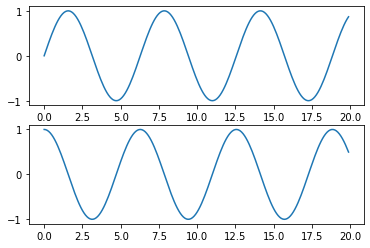

In [84]:
# Create the main figure
plt.figure()
# The first of two panels
plt.subplot(2, 1, 1) # (rows, columns, panel number)
plt.plot(x, np.sin(x))
# The second panel
plt.subplot(2, 1, 2)
plt.plot(x, np.cos(x));

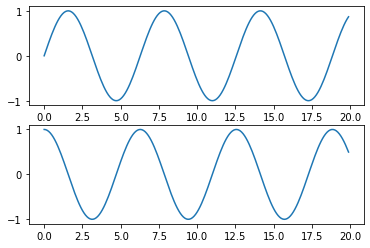

In [85]:
# Create an array of two Axes objects
fig, ax = plt.subplots(2)
# Call plot() method on the appropriate object
ax[0].plot(x, np.sin(x))
ax[1].plot(x, np.cos(x))

In [86]:
def plot_panels(n):
    """
    Produce a panel consisting of variable number of rows and 3 columns
    """
    if n%3==0:
        nrows =  int(n/3)
    else:
        nrows = n//3+1
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, figsize=(15,nrows*3))
    axes = ax.ravel()
    for i in range(n):
        axes[i].plot(x, np.sin(x))

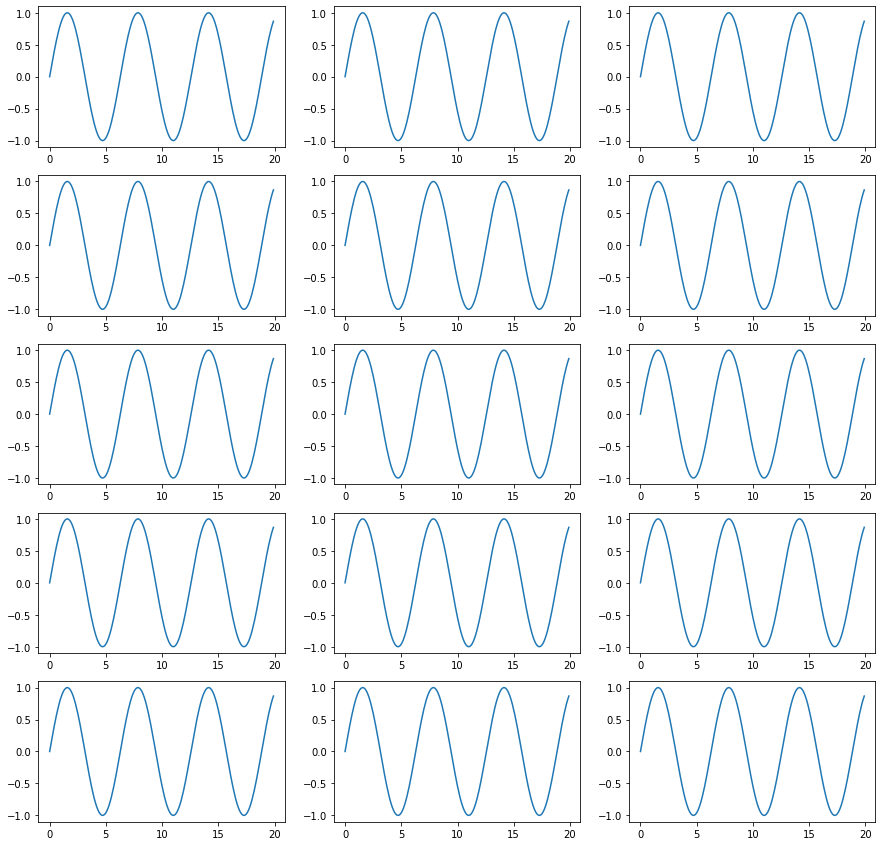

In [87]:
plot_panels(15)

### Setting and controlling image quality

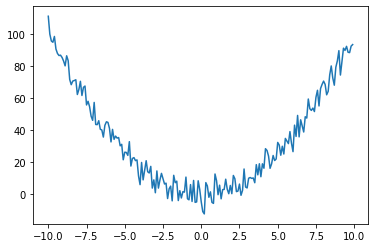

In [88]:
x = np.arange(-10,10,0.1)
y = x**2+5*np.random.normal(size=len(x))

plt.figure(figsize=(6,4))
plt.plot(x,y)

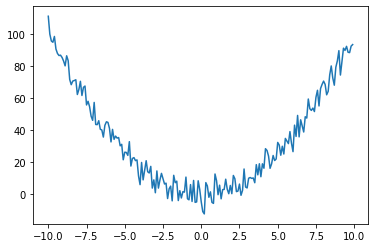

In [89]:
plt.figure(figsize=(6,4),dpi=72)
plt.plot(x,y)

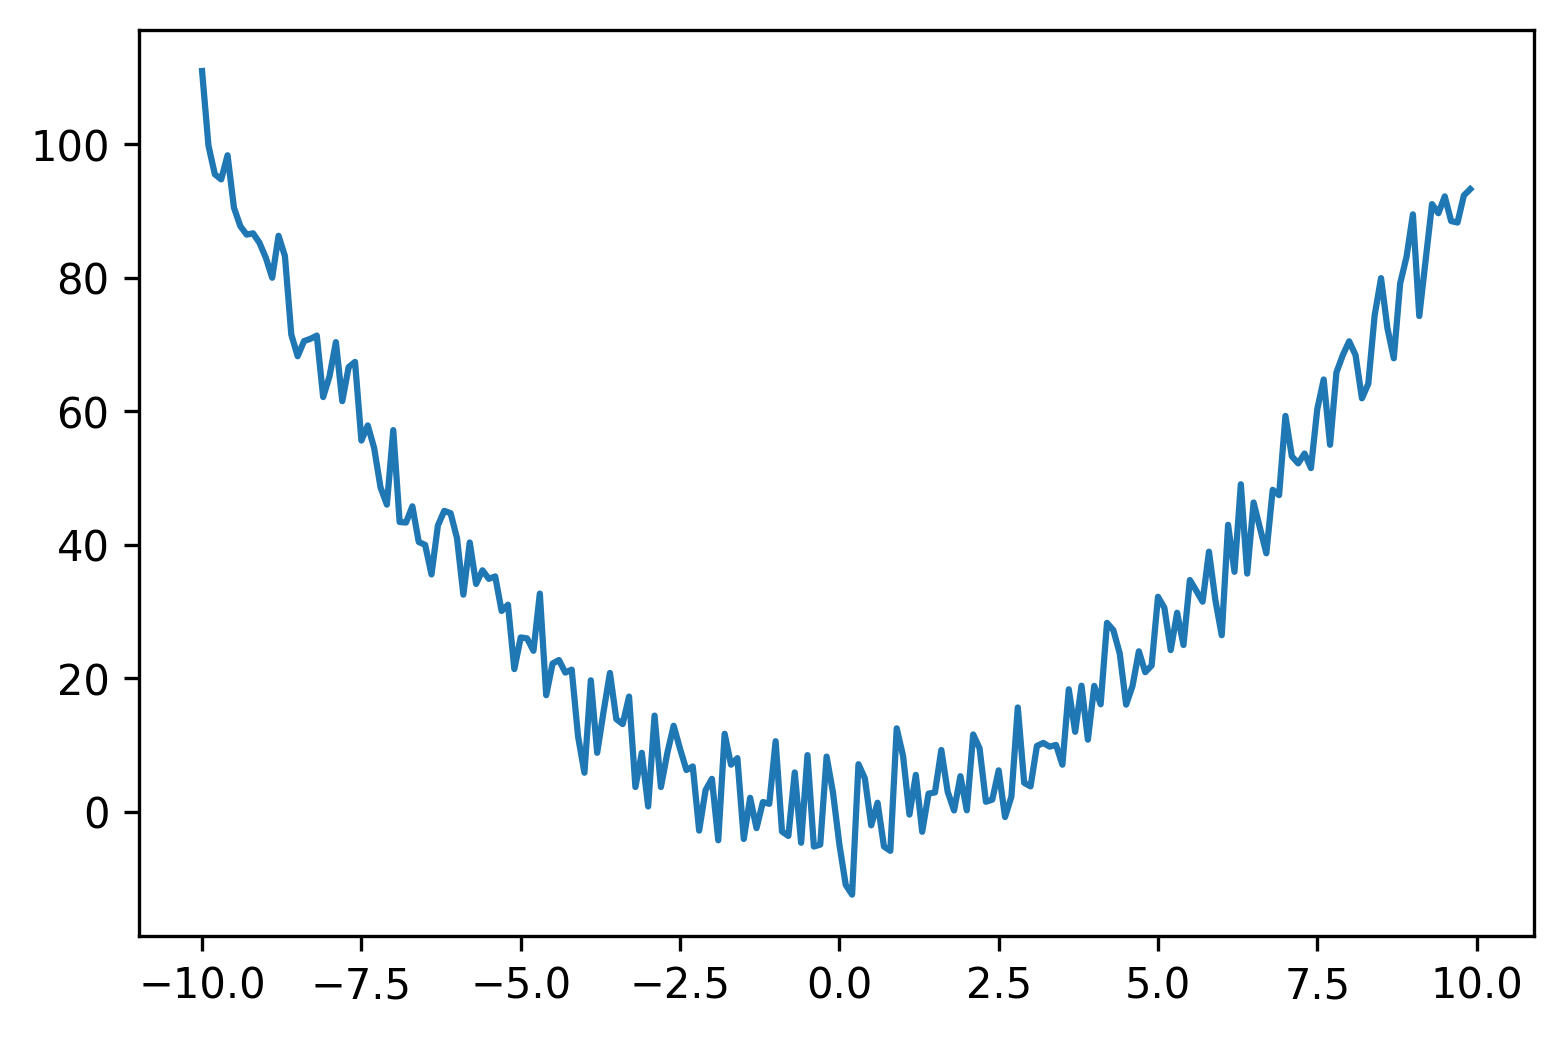

In [90]:
plt.figure(figsize=(6,4),dpi=300, frameon=False)
plt.plot(x,y)

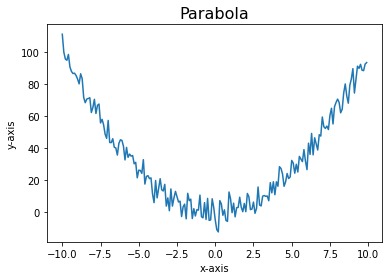

In [91]:
plt.figure(figsize=(6,4))
plt.plot(x,y)
plt.title("Parabola", fontsize=16)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.savefig("Parabola.png",
            dpi=300,
            format = 'png')

Text(0, 0.5, 'y-axis')

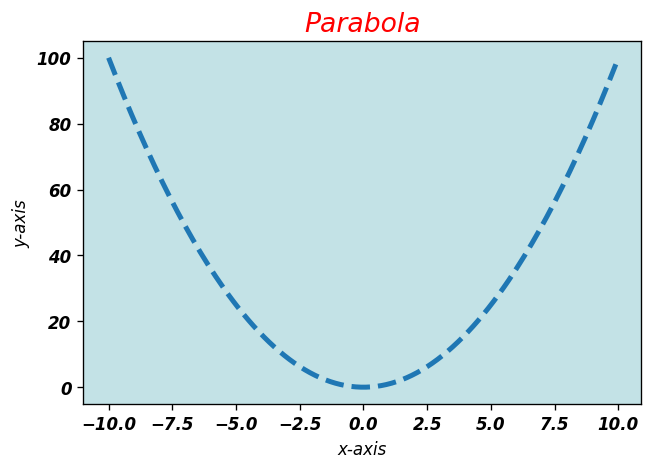

In [92]:
import matplotlib as mpl
# Data
x = np.arange(-10,10,0.1)
y = x**2
# Set all backend parameters
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['text.color'] = 'red'
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['axes.facecolor'] = '#c3e2e6'
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['font.style'] = 'italic'
mpl.rcParams['font.weight'] = 'heavy'
# Plot
plt.plot(x,y)
plt.title("Parabola", fontsize=16)
plt.xlabel('x-axis')
plt.ylabel('y-axis')

Text(0.5, 1.0, 'Linear')

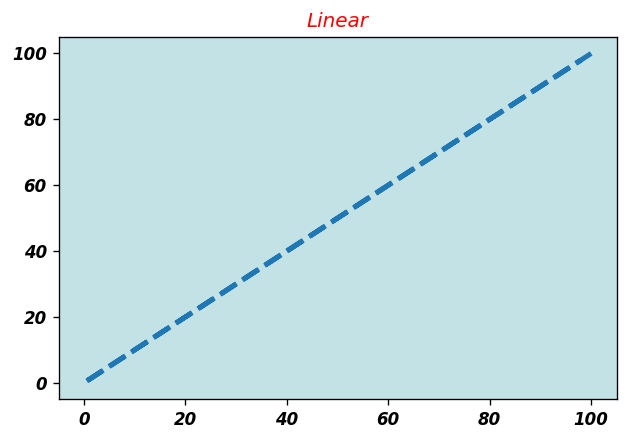

In [93]:
plt.plot(x**2,y)
plt.title("Linear")

### Tricks with Seaborn

In [94]:
import seaborn as sns

In [95]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [96]:
df_mpg = sns.load_dataset('mpg')

In [97]:
df_mpg.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model_year origin                       name  
0          70    usa  chevrolet chevelle malibu  
1          70    usa          buick skylark 320  
2          70    usa         plymouth satellite  
3          70    usa              amc rebel sst  
4          70    usa                ford torino

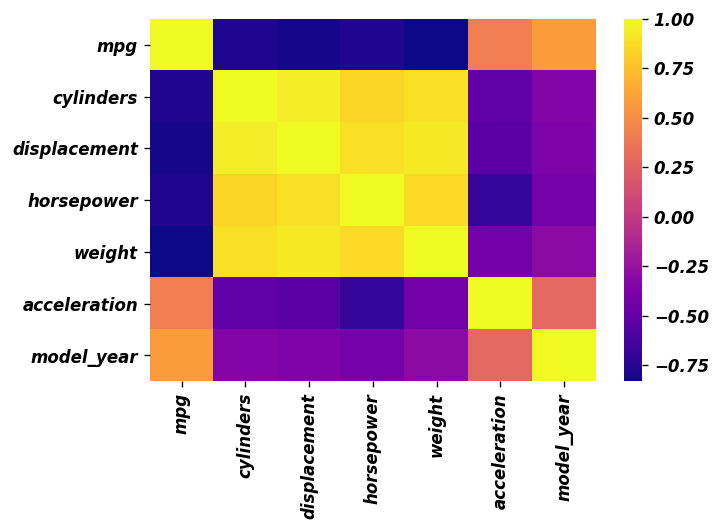

In [99]:
mpg_corr = df_mpg.corr()
sns.heatmap(mpg_corr,cbar=True,cmap='plasma')
plt.show()